In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
df = pd.read_csv("HR-Employee-Attrition.csv")

In [3]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

Dataset Shape: (1470, 35)

Column Names:
 Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

Missing Values:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField     

In [4]:
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})

In [5]:
print("\nAttrition Value Counts:\n", df["Attrition"].value_counts())


Attrition Value Counts:
 Attrition
0    1233
1     237
Name: count, dtype: int64


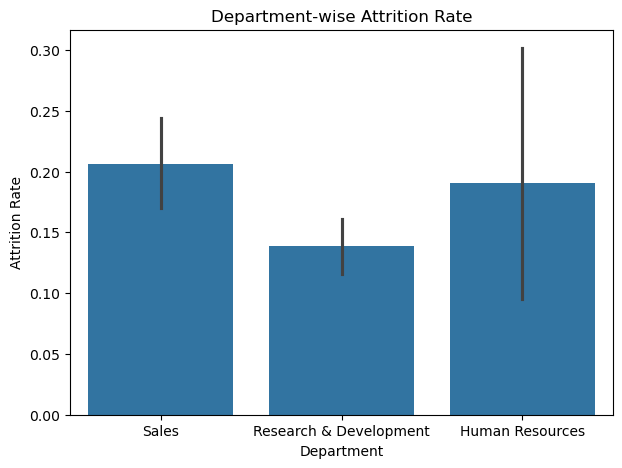

In [6]:
plt.figure(figsize=(7,5))
sns.barplot(x="Department", y="Attrition", data=df, estimator=np.mean)
plt.title("Department-wise Attrition Rate")
plt.ylabel("Attrition Rate")
plt.show()

In [13]:
df["SalaryBand"] = pd.qcut(df["MonthlyIncome"], 4, labels=["Low", "Mid-Low", "Mid-High", "High"])


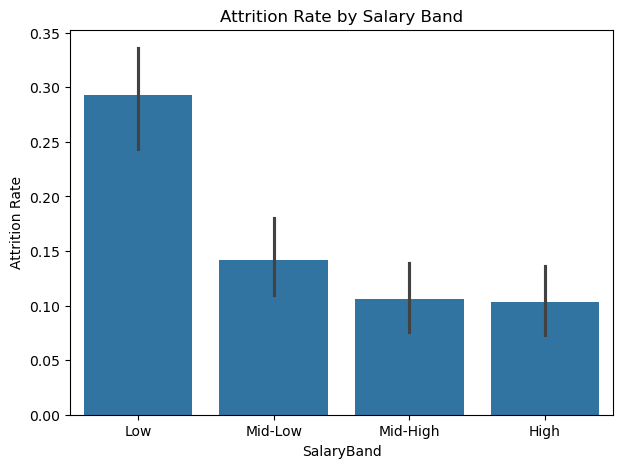

In [15]:
plt.figure(figsize=(7,5))
sns.barplot(x="SalaryBand", y="Attrition", data=df, estimator=np.mean)
plt.title("Attrition Rate by Salary Band")
plt.ylabel("Attrition Rate")
plt.show()

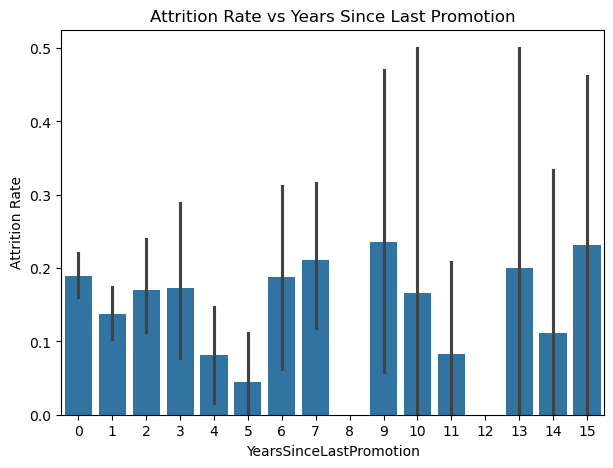

In [17]:
plt.figure(figsize=(7,5))
sns.barplot(x="YearsSinceLastPromotion", y="Attrition", data=df, estimator=np.mean)
plt.title("Attrition Rate vs Years Since Last Promotion")
plt.ylabel("Attrition Rate")
plt.show()

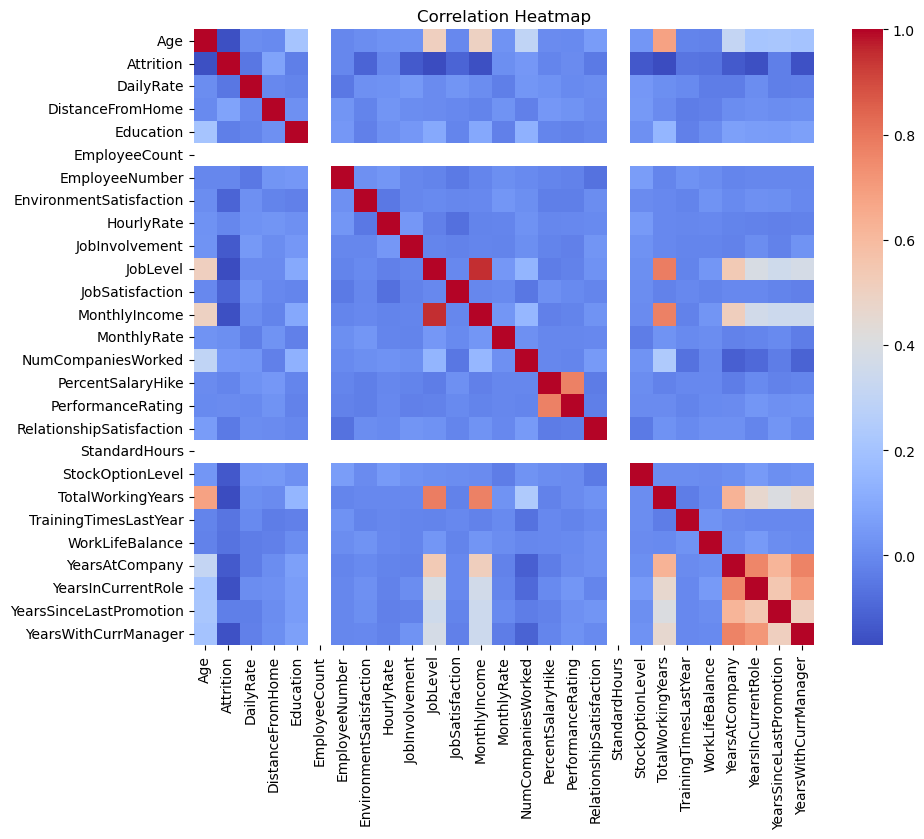

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [21]:
# CLASSIFICATION MODEL

In [23]:
X = df.drop(columns=["EmployeeNumber", "Attrition", "Over18", "StandardHours", "EmployeeCount"], errors="ignore")
y = df["Attrition"]

In [25]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [27]:
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [31]:
log_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

In [33]:
log_pipeline.fit(X_train, y_train)
y_pred_log = log_pipeline.predict(X_test)

In [35]:
print("\n--- Logistic Regression Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


--- Logistic Regression Results ---
Accuracy: 0.8858695652173914

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.93       309
           1       0.77      0.41      0.53        59

    accuracy                           0.89       368
   macro avg       0.84      0.69      0.73       368
weighted avg       0.88      0.89      0.87       368



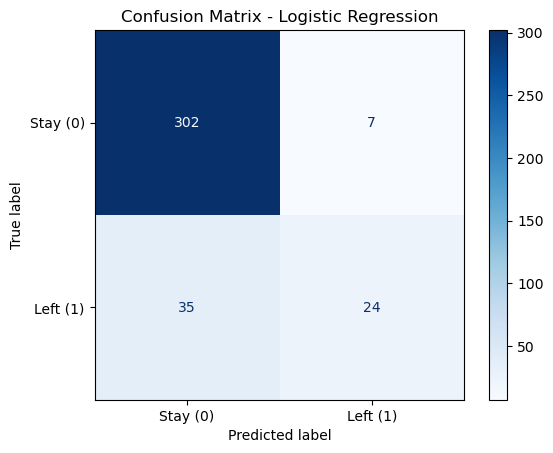

In [37]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_log), display_labels=["Stay (0)", "Left (1)"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [39]:
!pip install shap


In [40]:
import shap

In [43]:
print("\n--- SHAP Analysis for Logistic Regression ---")


--- SHAP Analysis for Logistic Regression ---


In [45]:
X_train_transformed = log_pipeline.named_steps["preprocessor"].transform(X_train)
X_test_transformed = log_pipeline.named_steps["preprocessor"].transform(X_test)

In [47]:
num_features = numeric_features
cat_features = list(log_pipeline.named_steps["preprocessor"]
                    .named_transformers_["cat"].get_feature_names_out(categorical_features))
feature_names = num_features + cat_features

In [49]:
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

In [51]:
explainer_log = shap.LinearExplainer(log_pipeline.named_steps["classifier"], X_train_df)
shap_values_log = explainer_log(X_test_df)

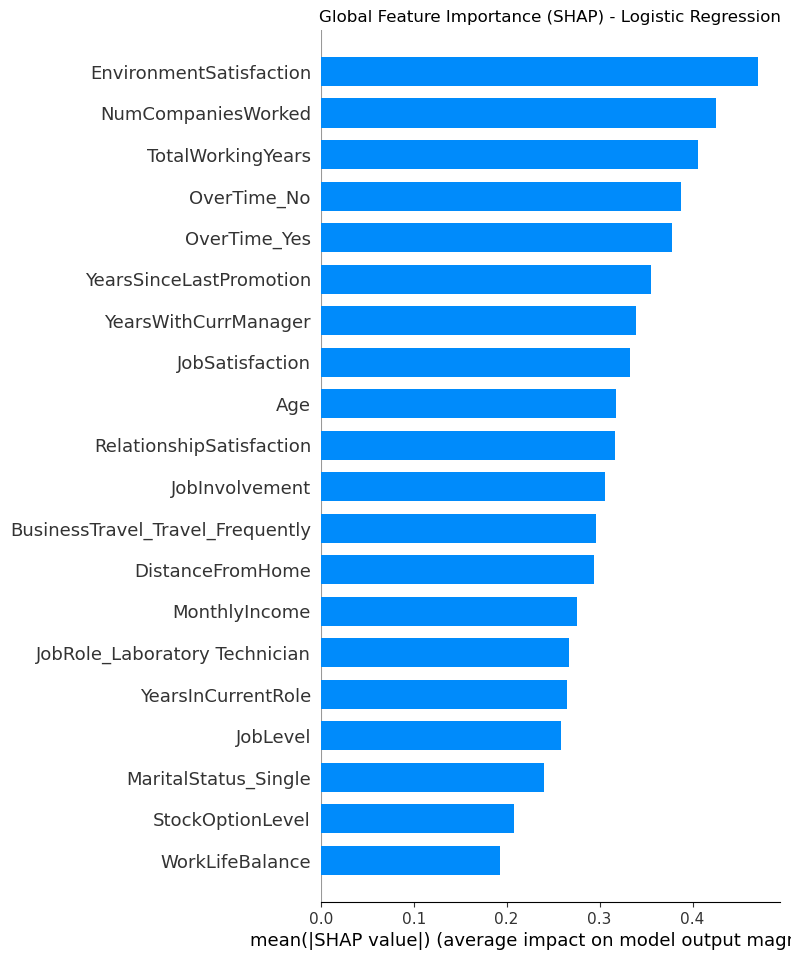

In [53]:
shap.summary_plot(shap_values_log, X_test_df, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP) - Logistic Regression")
plt.show()

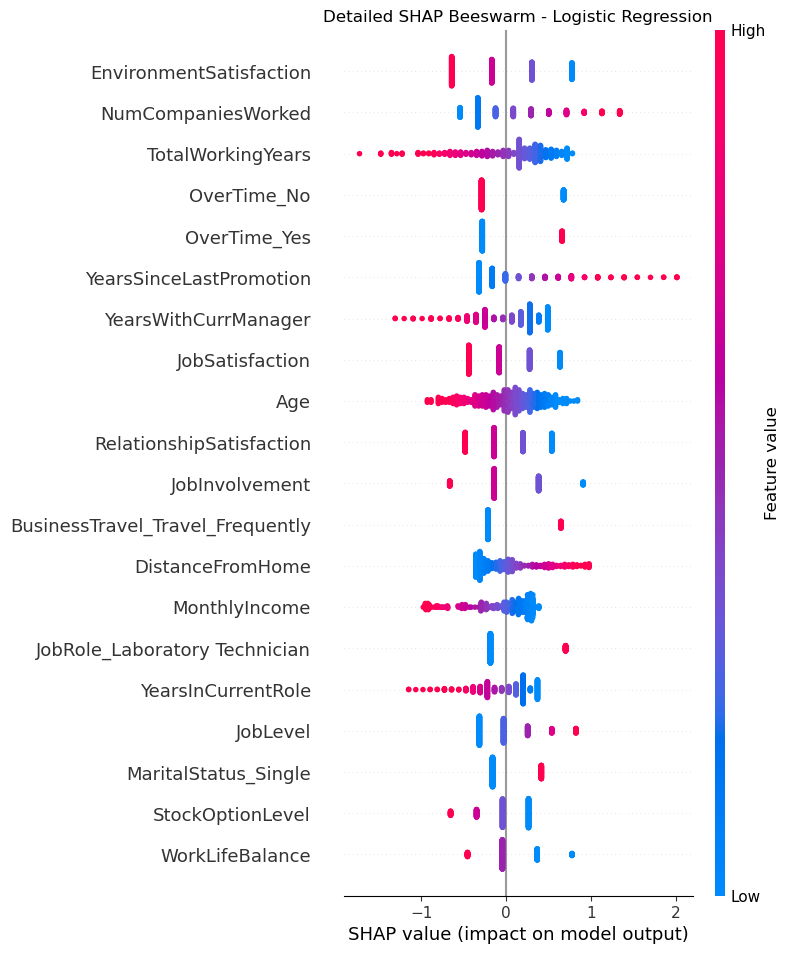

In [55]:
shap.summary_plot(shap_values_log, X_test_df, show=False)
plt.title("Detailed SHAP Beeswarm - Logistic Regression")
plt.show()

In [57]:
df_export = df.copy()

In [61]:
df_export["Attrition_Predicted_Logistic"] = log_pipeline.predict(X)


In [63]:
export_path = "hr_attrition_cleaned_for_powerbi.csv"
df_export.to_csv(export_path, index=False)
export_path

'hr_attrition_cleaned_for_powerbi.csv'